## Custom Segmentation Algorithm Profling

Notebook to profile segmentation implementation ([spheroid_cytometer.py](spheroid_cytometer.py)) for performance deficiencies.

In [1]:
%matplotlib inline
%run spheroid_cytometer.py
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from scipy import ndimage
from skimage import feature
from scipy import ndimage
from skimage import morphology
from skimage import filters
from cytokit.ops import cytometry as cytometer_op
from cytokit.ops import tile_generator
from cytokit import math as ck_math
from cytokit import config as ck_config

In [2]:
from itkwidgets import view

In [3]:
exp_name = '20190215-mc38-dmso-control'
exp_dir = 'XY03'
data_dir = osp.join(os.environ['CYTOKIT_DATA_DIR'], 'cytokit', 'mc38-spheroid', exp_name, exp_dir, 'raw')
config_dir = osp.join(os.environ['CYTOKIT_REPO_DIR'], 'pub', 'config', 'mc38-spheroid')
config = ck_config.load(config_dir)
os.environ['CYTOKIT_PATH_FORMATS'] = 'get_default_path_formats("1_' + exp_dir + '_{tile:05d}_Z{z:03d}_CH{channel:d}.tif")'
config.register_environment()

In [4]:
tile_gen = tile_generator.CytokitTileGenerator(config, data_dir, 0, 2)

In [5]:
tile = tile_gen.run()
tile.shape

(1, 26, 3, 1440, 1920)

In [493]:
from skimage import transform
img = tile[0, :, 0]
img = transform.rescale(img, (1, 1, 1), multichannel=False, preserve_range=True, anti_aliasing=True, mode='reflect').astype(img.dtype)
img.shape, img.dtype

((26, 1440, 1920), dtype('uint16'))

In [494]:
view(img)

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUS3; proxy of <Swig Object of type 'itkIm…

In [495]:

def preprocess_slice(img):
     # Verify 8 or 16 bit type before forcing to 8 bit (for median filtering)
    assert img.dtype in [np.uint8, np.uint16], 'Expecting 8 or 16 bit image but got type %s' % img.dtype
    if img.dtype == np.uint16:
        img = exposure.rescale_intensity(img, out_range='uint8').astype(np.uint8)
    assert img.dtype == np.uint8
    
    # Preprocess to remove outliers and blur
    img = filters.median(img, selem=morphology.disk(3))
    #img = filters.gaussian(img, sigma=1)

    # Median requires 8 or 16 bit images (or a warning is thrown) but gaussian filter
    # will convert result per img_as_float conventions leaving 0-1 image (verify that
    # and stretch to 0-1)
#     assert img.min() >= 0 and img.max() <= 1, \
#         'Expecting 0-1 image but got range %s - %s' % (img.min(), img.max())
    img = exposure.rescale_intensity(img.astype(float), out_range=(0, 1)).astype(np.float32)
    assert len(np.unique(img)) > 2
    assert img.min() == 0 and img.max() == 1

    # Run open-close morphological reconstruction
#     img_seed = morphology.erosion(img, selem=morphology.disk(3))
#     img = morphology.reconstruction(img_seed, img, method='dilation')
#     img_seed = morphology.dilation(img, selem=morphology.disk(3))
#     img = morphology.reconstruction(img_seed, img, method='erosion')
    return img

def preprocess(img):
    if img.ndim not in [2, 3]:
        raise ValueError('Expecting 2 or 3D grayscale image, not shape {}'.format(img.shape))
    if img.ndim == 2:
        img = img[np.newaxis]
    return np.stack([preprocess_slice(img[i]) for i in range(img.shape[0])])


In [9]:
img_prep = preprocess(img)
img_prep.min(), img_prep.max()

(0.0, 1.0)

In [76]:
# view(np.stack([
#     ndimage.gaussian_filter(img_prep[13], (s, s))
#     for s in [4, 8, 16, 32, 65]
# ]))

In [520]:

def flat_ball(r, rz):
    return np.stack([
        np.pad(morphology.disk(rz), r-rz, 'constant'),
        morphology.disk(r),
        np.pad(morphology.disk(rz), r-rz, 'constant'),
    ])

def prep(img):
    #img = img - ndimage.gaussian_filter(img, sigma=(0, s, s))
    img = ndimage.median_filter(img, size=(1, 3, 3))
    img = img_as_float(img)
    return img

#gimage = standardize(img_prep, 16)
gimage = prep(img)

gimage = gimage - ndimage.gaussian_filter(gimage, sigma=(0, 16, 16), mode='reflect')
#gimage = gimage - ndimage.gaussian_filter(gimage, sigma=(0, 16, 16), mode='reflect')
gimage = exposure.rescale_intensity(gimage, out_range=(0, 1))
gimage = ndimage.generic_gradient_magnitude(gimage, ndimage.sobel)
#gimage = np.stack([filters.sobel(gimage[i]) for i in range(gimage.shape[0])])
gimage = exposure.rescale_intensity(gimage, out_range=(0, 1))
print(gimage.min(), gimage.max(), len(np.unique(gimage)))
gimage = gimage > filters.threshold_li(gimage)
#gimage = ndimage.binary_closing(gimage, structure=flat_ball(3, 1))

#gimage = ndimage.binary_opening(gimage, structure=ndimage.morphology.generate_binary_structure(3, 2))
#gimage = morphology.remove_small_objects(gimage, min_size=32)

#gimage = np.abs(gimage)


0.0 1.0 71884800


In [521]:
#gimage = exposure.rescale_intensity(gimage.astype(np.float32), (0, 1))
gimage.min(), gimage.max(), len(np.unique(gimage))

(False, True, 2)

In [522]:
view(gimage.astype(np.float32))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

In [490]:
from skimage import img_as_float
img_as_float(img).max()

0.9999847409781033

In [492]:
img_bound = np.stack([segmentation.find_boundaries(gimage[i]) for i in range(gimage.shape[0])])
view(img_bound.astype(np.float32) * .5 + img_as_float(img).astype(np.float32))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

In [158]:
#img_si = feature.shape_index(img, sigma=10)
#img_gd = ndimage.gaussian_gradient_magnitude(img, 2)
from cytokit import io as ck_io
#ck_io.save_image('/lab/data/tmp/test.tif', img_gd.astype(np.float32)[np.newaxis, :, np.newaxis])
ck_io.save_image('/lab/data/tmp/test_true.tif', img.astype(np.float32)[np.newaxis, :, np.newaxis])
ck_io.save_image('/lab/data/tmp/test_prep.tif', img_prep.astype(np.float32)[np.newaxis, :, np.newaxis])

In [380]:
# def ball(r, nr, nc, nz):
#     res = transform.resize(morphology.ball(r), (nz, nr, nc), mode='constant', anti_aliasing=False, preserve_range=True, clip=True)
#     return (res > 0).astype(int)
# imgball = ball(15, 21, 21, 3)
# plt.imshow((imgball * np.arange(imgball.shape[0])[:, np.newaxis, np.newaxis]).max(axis=0))
# plt.colorbar()

In [176]:
from skimage.segmentation import morphological_geodesic_active_contour, inverse_gaussian_gradient
from cytokit import io as ck_io

import cv2

def winVar(img, wlen):
    wmean, wsqrmean = (cv2.boxFilter(x, -1, (wlen, wlen),
        borderType=cv2.BORDER_REFLECT) for x in (img, img*img))
    return wsqrmean - wmean*wmean



def local_var(img, shape):
    kernel = shape / shape.sum()
    img_mean = ndimage.convolve(img, kernel)
    return (img - img_mean)**2


#     win_mean = ndimage.uniform_filter(img**2,shape)
#     win_sqr_mean = ndimage.uniform_filter(img**2,shape)
#     return win_sqr_mean - win_mean**2
#     return ndimage.generic_filter(img, np.var, footprint=shape)


#gimage = ndimage.median_filter(img, footprint=morphology.ball(3))
#print(gimage.min(), gimage.max())

gimage = exposure.rescale_intensity(img_prep.astype(float), out_range=(0, 1))
#gimage = exposure.rescale_intensity(img.astype(float), out_range=(0, 1))
#gimage = ndimage.gaussian_laplace(gimage, sigma=(.1, 1, 1))
gimage = ndimage.generic_gradient_magnitude(gimage, ndimage.sobel)
# High band-pass
gimage = np.abs(gimage - ndimage.gaussian_filter(gimage, sigma=(.1, 5, 5)))
gimage = exposure.rescale_intensity(gimage, out_range=(0, 1)).astype(np.float32)

gimage = gimage > filters.threshold_otsu(gimage)
gimage = ndimage.binary_closing(gimage, structure=ball(8, 17, 17, 3))
#gimage = local_var(gimage.astype(float), flat_ball().astype(float))

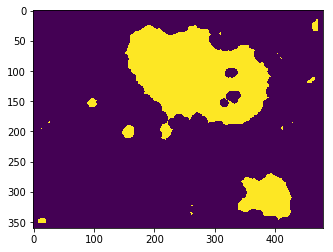

In [177]:
plt.imshow(gimage[8])

In [178]:
ck_io.save_image('/lab/data/tmp/test_gimage.tif', np.stack([
    gimage.astype(np.float32),
    img.astype(np.float32)
], 1)[np.newaxis])

In [64]:
gimage.min(), gimage.max()

(1.4491810533713392e-17, 0.7199063168027905)

In [ ]:
plt.imshow(img_si[z_idx])

In [19]:
op = cytometer_op.Cytometry2D(config)

In [6]:
op.initialize()

In [7]:
# !pip install line_profiler
%load_ext line_profiler

In [12]:
img_seg = op.cytometer.segment(tile[0, :, 0])
img_seg.shape

(26, 6, 1440, 1920)

In [13]:
stats = op.cytometer.quantify(tile, img_seg, channel_names=config.channel_names, morphology_features=True, nucleus_intensity=['mean', 'sum'])

In [14]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 33 columns):
id                            1014 non-null int64
x                             1014 non-null float64
y                             1014 non-null float64
z                             1014 non-null int64
cm:size                       1014 non-null int64
cm:diameter                   1014 non-null float64
cm:perimeter                  1014 non-null float64
cm:solidity                   1014 non-null float64
nm:size                       1014 non-null int64
nm:diameter                   1014 non-null float64
nm:perimeter                  1014 non-null float64
nm:solidity                   1014 non-null float64
ci:BF:mean                    1014 non-null float64
ci:LIVE:mean                  1014 non-null float64
ci:DEAD:mean                  1014 non-null float64
ni:BF:mean                    1014 non-null float64
ni:LIVE:mean                  1014 non-null float64
ni:DEAD:mean     

In [21]:
%lprun -f op.cytometer.segment img_seg = op.cytometer.segment(tile[0, :, 0])

Timer unit: 1e-06 s

Total time: 9.36233 s
File: /lab/repos/cell-image-analysis/analysis/experiments/spheroid/20190215-mc38-dmso-control/spheroid_cytometer.py
Function: segment at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                               def segment(self, img, **kwargs):
    22         1         11.0     11.0      0.0          assert img.ndim == 3, 'Expecting 3D image, got shape %s' % img.shape
    23                                                   
    24                                                   # Run max-z projection to create single 2D image (but record initial number of z planes)
    25         1          6.0      6.0      0.0          nz = img.shape[0]
    26         1     137033.0 137033.0      1.5          img = img.max(axis=0)
    27                                                   
    28                                                   # Verify 8 or 16 bit type before forcing to 8 bit (for median 